## TIM NEP CALCULATION
JPF 09Oct2020 Created

JPF 07Apr2023 Updated with more sensible treatment of dielectrics, mirror emissivity/scattering, warm spills

What it does:
 - Uses Isaac's POP spreadsheet to find spills for specific pixels
 - Incorporates mirror emissivity and aperture elements
 - Incorporates grating blaze efficiency (assumes lost to box)
 - Uses Isaac's FWHM bandwidth estimates for these pixels
 - Assumes each pixel further has a wide band that terminates within the optics box (Toptics)
 - Computes NEP and power budgets for only these pixels (generally array edges)
 - Optics temperatures and emissivities (and spills to sky) are defined together in one block below
 - Complements other versions that makes nice spectral plots, but can't track variation in spill, resolution
 
 
 Things that aren't great:
 - Too much clumsy code repetition (LW/SW, stage to stage)
 - The data structure that comes out of the Excel read is clumsy
 - Resolving power (bandwidth of each detector) is handled crudely and uniformly; should improve from sims
 

In [1]:
# packages
import os
import numpy as _np
import scipy.constants as _con
from scipy.integrate import quad
from scipy.integrate import trapz
import pandas as _pd
import matplotlib.pyplot as _plt

# constants
k = _con.k  # Boltzmann constant (J/K)
c = _con.c  # Speed of light (m/s)
h = _con.h  # Planck's Constant (J-s)

In [2]:
# physics utility functions
def n_occ (T,v):
    """Photon mode occupation number of a black body of temperature T at frequency v"""
    return 1./(_np.exp(h*v/(k*T))-1)

def IBlackBody (T, v, pol=False):
    """Planck's Law spectral radiance - radiated power (in the normal direction) per steradian
    per square meter per Hertz at frequency v - for a blackbody at temperature T.
    If pol=True, returns for one polarization (half the power of the standard expression)."""
    polfactor = 1 if pol else 2
    return polfactor * h/(c**2)*(v**3)*n_occ(T,v)

def PBBSingleModed (T, v1=0, v2=_np.inf, pol=False):
    """Planck's Law radiative power received by an ideal single-moded
    receiver sensitive over frequency band [v1,v2] observing a blackbody at temperature T.
    If pol=True, returns for one polarization (half the power of the standard expression)."""
    (out,err) = quad(lambda v: IBlackBody(T,v,pol=pol)*(c/v)**2, v1, v2)
    return out

def NEP_photon (T,eta,v1=0,v2=_np.inf, pol=False, narrow=False):
    """Photon NEP [W/rtHz] for a noiseless detector observing temperature T
    with quantum efficiency eta over a frequency band [v1,v2].
    Defined with an integral to hander wider bands; faster with narrow=True."""
    polfactor = 1 if pol else 2 # sum incoherently over two polarization modes
    if narrow:
        v0 = (v1+v2)/2.
        dv = (v2-v1)
        return _np.sqrt(2*polfactor)*h*v0*_np.sqrt(dv*eta*n_occ(T,v0)*(1+eta*n_occ(T,v0)))
    else:
        integrand = lambda v: eta*(h*v)**2*n_occ(T,v) + (eta*h*v*n_occ(T,v))**2
        # integrate and incorporate the factor of 2 from NEP definition
        return _np.sqrt(2*polfactor*quad(integrand,v1,v2)[0])

In [3]:
# effects from realistic optical elements
def DielectricEmissivity(tan_delta, n, t, v):
    '''Emissivity of a dielectric at frequency v,
    given refractive index, loss tangent, and thickness (mm)'''
    alpha_z = 2*_np.pi*tan_delta*n*(t*1e-3)*v/c
    return 1-_np.exp(-alpha_z)

def RuzeLoss(rms,lam):
    '''Simple model of fractional Ruze loss from a rough reflector'''
    return 1-_np.exp(-(4*_np.pi*rms/lam)**2)

In [4]:
class amModel:
# Encapsulates an am atmosphere model
# Columns: f (GHz), tx , Tb (K), I (watt*cm-2*GHz-1*sr-1)
# tx: transmittance
# Tb: Planck brightness temperature (redundant with I)
# I: Spectral radiance (unpolarized)
    def __init__(self, filename, label=None):
        '''Initialize a new am model (code assumes we know the units!!!)'''
        self.atmo = _pd.read_csv(filename,header = None, sep=' ', names=['vGHz','tx','Tb','I'])
        self.atmo['n'] = self.atmo['I']*1e-5*c**2/(2*h*(self.atmo['vGHz']*1e9)**3)
        self.label=label
    def I(self,v):
        '''Atmospheric intensity as a function of frequency (W/m2/Hz/sr, dual-pol)'''
        return _np.interp(v/1e9,self.atmo['vGHz'],self.atmo['I'])*1e-5 # intensity in W/m2/Hz/sr (dual-pol)
    def n(self,v):
        '''Mode occupation number '''
        return self.I(v)*c**2/(2*h*v**3) # mode occupation number as a function of frequency
    def P(self,v1,v2,pol=False):
        """Returns the unobstructed single-moded power from the atmosphere model in a given band"""
        # implemented numerically, assuming that the data file is sampled much more finely than we need
        polfactor = 2 if pol else 1 # Iatm is unpolarized, so we divide by 2 for single-pol
        temp = self.atmo[(self.atmo['vGHz']>=v1/1e9) & (self.atmo['vGHz']<v2/1e9)]
        return trapz(temp['I']*1e-5 * (c/(temp['vGHz']*1e9))**2,x=temp['vGHz']*1e9)/polfactor
    def NEP(self,eta,v1,v2,pol=False):
        """Atmospheric NEP associated with a given band observed with efficiency eta"""
        # implemented numerically, assuming that the data file is sampled much more finely than we need
        polfactor = 1 if pol else 2 # sum incoherently over two polarization modes
        temp = self.atmo[(self.atmo['vGHz']>=v1/1e9) & (self.atmo['vGHz']<v2/1e9)]
        return _np.sqrt( polfactor * trapz( 
            (h*temp['vGHz']*1e9)**2*eta*temp['n'] + (eta*h*temp['vGHz']*1e9*temp['n'])**2,
            x=temp['vGHz']*1e9))

In [5]:
class POPanalysis:
    # Encapsulates Isaac's POP analysis
    # should make this more clever about identifying file features, but nah
    def __init__(self,filename):
        assert os.path.isfile(filename)
        self.filename = filename
    
    def parsePOPsheet(self,sheetname):
        # first, read in the whole sheet
        xls = _pd.read_excel(self.filename,sheet_name=sheetname,header=None)
        # construct a DataFrame with entries for each pixel
        df = _pd.DataFrame(columns=['Location','Wavelength','Spill'])
        start_row = 0
        this_entry = 0
        while xls.iloc[start_row,0][0]=='(': # new pixel!
            px = xls.iloc[start_row,0] # pixel identifier
            wvl = xls.iloc[start_row,1] # wavelength (um)
            x = _pd.DataFrame(data=_np.array(xls.iloc[(start_row+2):(start_row+9),1:6].copy()),index=xls.iloc[(start_row+2):(start_row+9),0].copy(),
                            columns=['TotalEff','Spill','RuzeLoss','Loss','Eff'])
            # tweak some things
            x['TotalEff']/=100.
            x['Spill']/=100.
            x['RuzeLoss']/=100.
            x['Loss']/=100.
            # make an entry
            df.loc[this_entry]={'Location':px,'Wavelength':wvl,'Spill':x.copy()}
            start_row += 10
            this_entry +=1
        return df

In [6]:
# ===== define the warm and cold optics =====

epsMirror = 0.01 # Good optical surfaces, but not implausibly good
epsMylar = 0.05 # Not great, not terrible...

nPP = 1.5 # Polypropylene refractive index
tandPP = 6e-4 # Polypropylene loss tangent

# Warm primary mirror (for all ambient temperature optics)
Twarm = 250. # Kelvin
#epsPrimary = epsMirror # Emissivity of the primary mirror
rmsMirror = 3. # micron for warm mirrors
rmsMirrorCold = 3. # micron for cold mirrors

# How much can we spill to the sky from the warm stages?
# Setting these to 0 terminates all spilled power warm, 1 assumes all goes to the cold sky
fSkySecondary = 0.98 # Miss the secondary, head to the sky
fSkyPrimary = 0.92 # Miss the primary, bounce 1-2x off mylar
fSkyObscuration = 0.96 # Basically all to sky
fSkySpider = 0.9 # two bounces from mylar?

# How much does each filter reflect
Rfilter = 0.04

# Window: 0.8mm thick UHMWPE
Twin = 250. # Kelvin
Zwin = 0.8 # mm thick
Rwin = 0.04 # reflection
#epsWin = 0.005 # Emissivity

# VCS2 Filters: count 250K (PP + shader) and VCS2 (shader + TIR)
Tvcs2 = 175. # Kelvin
Tvcs2filt = 220 # Kelvin
Zvcs2filt = 0.5 + 0.004 + 0.004 + 0.020 # millimeters
Rvcs2filt = 1-(1-Rfilter)**4 # assume 4% / filter
#epsVCS2 = 0.005

# VCS1 Filters (TIR)
Tvcs1 = 65. # Kelvin
Tvcs1filt = 100 # Kelvin
Zvcs1filt = 0.020 # millimeters
Rvcs1filt = Rfilter # assume 4% / filter
#epsVCS1 = 0.01

# Cold optics: all mirrors
# Cold optics filters
Zoffnerfilt = 0.133 # millimeters
Roffnerfilt = Rfilter # assume 4% / filter
ZslitfiltSW = 0.242 # millimeters
ZslitfiltLW = 0.333 # millimeters
Rslitfilt = Rfilter # assume 4% / filter
ZfpufiltSW = 0.508 # millimeters
ZfpufiltLW = 0.682 # millimeters
Rfpufilt = 1-(1-Rfilter)**2 # assume 4% / filter

# Grating blaze factor: assume 1-fBlaze gets lost to the box
fBlaze = 0.7
# Cold optics box, assumed visible across full band of each camera
Toptics = 4.8 # Kelvin

# Detector
Tdet = 0.25 # Kelvin
detEff = 0.95 # efficiency of the detector itself
pol=False # polarization-insensitive
#Actual band, but that's too narrow. Widen by 20%
#SWlambda = _np.array([240e-6,317e-6]) # meters
#LWlambda = _np.array([317e-6,420e-6]) # meters
SWlambda = _np.array([240e-6*0.8,317e-6*1.2]) # meters
LWlambda = _np.array([317e-6*0.8,420e-6*1.2]) # meters
SWnu = c/SWlambda[::-1] # Hz
LWnu = c/LWlambda[::-1] # Hz
#cutofflambdaLW = 425. # um; 249 um diameter circular waveguide

# Atmosphere
atmo = amModel('Antarctic_DJF_37km_0_2000_10M_45_1.out',label='37km')

In [7]:
# load Isaac's optics POP analysis
POP = POPanalysis('../optics_analysis/ReverseModel_POP_Analysis.xlsx')
LWpop = POP.parsePOPsheet('LW 3mm Slit R_335 Spill')
SWpop = POP.parsePOPsheet('SW 2mm Slit R_435 Spill')
# SPECTRAL BANDWIDTH
# VERSION 1: add in by hand Isaac's estimates of bandwidth
# assume symmetric spatially
#SWpop['FWHM'] = [1.43,1.50,1.43,1.70,1.29,1.70,1.97,1.43,1.97,1.29,1.36,1.50] # microns
# totally fake the LW numbers for now
#LWpop['FWHM'] = LWpop['Wavelength']/155.0 # scaled mean resolving power above by spectrometer summary R ratio
# VERSION 2: use design resolving power
SWpop['FWHM'] = SWpop['Wavelength']/250. # design R=260.42
LWpop['FWHM'] = LWpop['Wavelength']/250. # design R=257.59
# put in frequency units (Hz)
SWpop['v'] = c/(SWpop['Wavelength']*1e-6)
SWpop['dv'] = SWpop.v * (SWpop.FWHM/SWpop.Wavelength)
LWpop['v'] = c/(LWpop['Wavelength']*1e-6)
LWpop['dv'] = LWpop.v * (LWpop.FWHM/LWpop.Wavelength)

# DELETE FINAL ROWS FROM ISAAC'S SW SHEET, WHICH ARE BAD!!
SWpop=SWpop.drop([9,10,11],axis=0)

# In practice we only need the fractional spill at each stage

# TESTING
SWpop['Wavelength']/SWpop['FWHM']

0    250.0
1    250.0
2    250.0
3    250.0
4    250.0
5    250.0
6    250.0
7    250.0
8    250.0
dtype: float64

In [8]:
# summary structures: rows are pixels, columns are powers and such
bandsSW = _pd.DataFrame(data=SWpop.Location,columns=['Location'])
bandsLW = _pd.DataFrame(data=LWpop.Location,columns=['Location'])
for bands,pop in zip([bandsSW,bandsLW],[SWpop,LWpop]):
    # band definition
    bands['lam'] = pop.Wavelength
    bands['v'] = pop.v
    bands['dv'] = pop.dv
# TEST
print(bandsSW)

     Location     lam             v            dv
0   (73, -64)  235.60  1.272464e+12  5.089855e+09
1     (73, 0)  237.25  1.263614e+12  5.054457e+09
2    (73, 64)  235.60  1.272464e+12  5.089855e+09
3    (0, -64)  279.50  1.072603e+12  4.290411e+09
4      (0, 0)  281.40  1.065361e+12  4.261442e+09
5     (0, 64)  279.50  1.072603e+12  4.290411e+09
6  (-73, -64)  318.40  9.415592e+11  3.766237e+09
7    (-73, 0)  320.75  9.346608e+11  3.738643e+09
8   (-73, 64)  318.40  9.415592e+11  3.766237e+09


In [9]:
# optical loading model

# in-band power from each element
# each element we spill some power and have losses on a few mirrors
# Aperture stages and reflector loss are added to Isaac's sims after-market, so we implement them differently

for bands,pop,Zslitfilt,Zfpufilt in zip([bandsSW,bandsLW],[SWpop,LWpop],[ZslitfiltSW,ZslitfiltLW],[ZfpufiltSW,ZfpufiltLW]): # cycle over cameras
    # need to create the columns first b/c the indexing is complex
    prefixes = ['P','Eff','NEP']
    stages = ['Det','FPUfilt','Grating','Slit','Slitfilt','Lyot','Lyotfilt','VCS1','VCS2','Window','Secondary','Primary','Obscuration','Spider','Sky']
    for s in stages:
        for p in prefixes:
            bands[p+s]=0
    for idx in range(len(bands.index)): # cycle over pixels
        # preliminaries
        v1 = bands.loc[idx].v - bands.loc[idx].dv/2
        v2 = bands.loc[idx].v + bands.loc[idx].dv/2
        
        # FPU ASSEMBLY
        # detectors have some efficiency, but no significant photons
        bands.loc[idx,'EffDet'] = detEff
        bands.loc[idx,'PDet'] = 0
        bands.loc[idx,'NEPDet'] = 0
        # filters have reflection and loss (both to sub-Kelvin)
        loss = Rfpufilt + DielectricEmissivity(tandPP, nPP, Zfpufilt, bands.loc[idx].v)
        bands.loc[idx,'EffFPUfilt'] = (1-loss)*bands.loc[idx,'EffDet']
        bands.loc[idx,'PFPUfilt'] = bands.loc[idx,'EffDet']*loss*PBBSingleModed(Tdet, v1=v1, v2=v2, pol=pol)
        bands.loc[idx,'NEPFPUfilt'] = NEP_photon(Tdet,bands.loc[idx,'EffDet']*loss,v1=v1,v2=v2, pol=pol, narrow=True)
  
        # NOTE: EffFPUfilt represents the efficiency with which we see the optics box, even out-of-band
        
        # COLD OPTICS
        # grating has spill and blaze efficiency plus two reflective surfaces, all goes cold
        scatter = RuzeLoss(rmsMirrorCold,bands.loc[idx].v)
        lossmirror = epsMirror + scatter
        loss = pop.loc[idx].Spill.Spill.Grating + (1-fBlaze) + (1 - (1-lossmirror)**2)
        bands.loc[idx,'PGrating'] = bands.loc[idx,'EffFPUfilt']*loss*PBBSingleModed(Toptics, v1=v1, v2=v2, pol=pol)
        bands.loc[idx,'EffGrating'] = (1-loss)*bands.loc[idx,'EffFPUfilt']
        bands.loc[idx,'NEPGrating'] = NEP_photon(Toptics,loss*bands.loc[idx,'EffFPUfilt'],v1=v1,v2=v2, pol=pol, narrow=True)
        
        
        # Slit has spill plus four reflective surfaces, all goes cold
        # here and below, spill in the table has been re-normalized to total, so we need to undo that
        spill = pop.loc[idx].Spill.Spill.Slit / pop.loc[idx].Spill.TotalEff.Grating
        scatter = RuzeLoss(rmsMirrorCold,bands.loc[idx].v)
        lossmirror = epsMirror + scatter
        loss = spill + (1 - (1-lossmirror)**4)
        bands.loc[idx,'PSlit'] = bands.loc[idx,'EffGrating']*loss*PBBSingleModed(Toptics, v1=v1, v2=v2, pol=pol)
        bands.loc[idx,'EffSlit'] = (1-loss)*bands.loc[idx,'EffGrating']
        bands.loc[idx,'NEPSlit'] = NEP_photon(Toptics,loss*bands.loc[idx,'EffGrating'],v1=v1,v2=v2, pol=pol, narrow=True)
        
        # Slit has one filter; loss goes cold, no spill
        loss = Rslitfilt + DielectricEmissivity(tandPP, nPP, Zslitfilt, bands.loc[idx].v)
        bands.loc[idx,'PSlitfilt'] = bands.loc[idx,'EffSlit']*loss*PBBSingleModed(Toptics, v1=v1, v2=v2, pol=pol)
        bands.loc[idx,'EffSlitfilt'] = (1-loss)*bands.loc[idx,'EffSlit']
        bands.loc[idx,'NEPSlitfilt'] = NEP_photon(Toptics,loss*bands.loc[idx,'EffSlit'],v1=v1,v2=v2, pol=pol, narrow=True)
        
        # Lyot has spill plus five reflective surfaces, all goes cold
        spill = pop.loc[idx].Spill.Spill.Lyot / pop.loc[idx].Spill.TotalEff.Slit
        scatter = RuzeLoss(rmsMirrorCold,bands.loc[idx].v)
        lossmirror = epsMirror + scatter
        loss = spill + (1 - (1-lossmirror)**5)
        bands.loc[idx,'PLyot'] = bands.loc[idx,'EffSlitfilt']*loss*PBBSingleModed(Toptics, v1=v1, v2=v2, pol=pol)
        bands.loc[idx,'EffLyot'] = (1-loss)*bands.loc[idx,'EffSlitfilt']
        bands.loc[idx,'NEPLyot'] = NEP_photon(Toptics,loss*bands.loc[idx,'EffSlitfilt'],v1=v1,v2=v2, pol=pol, narrow=True)
        
        # Offner relay has one filter; loss goes cold, no spill
        loss = Roffnerfilt + DielectricEmissivity(tandPP, nPP, Zoffnerfilt, bands.loc[idx].v)
        bands.loc[idx,'PLyotfilt'] = bands.loc[idx,'EffLyot']*loss*PBBSingleModed(Toptics, v1=v1, v2=v2, pol=pol)
        bands.loc[idx,'EffLyotfilt'] = (1-loss)*bands.loc[idx,'EffLyot']
        bands.loc[idx,'NEPLyotfilt'] = NEP_photon(Toptics,loss*bands.loc[idx,'EffLyot'],v1=v1,v2=v2, pol=pol, narrow=True)
        
        ## TO DO: Add loss at Lyot stop for blackening to hid secondary obscuration
        
        # APERTURE STOPS AND FILTERS
        # VCS1 filter(s)
        refl = Rvcs1filt # reflected cold
        loss = DielectricEmissivity(tandPP, nPP, Zvcs1filt, bands.loc[idx].v)
        Prefl = bands.loc[idx,'EffLyotfilt']*refl*PBBSingleModed(Toptics, v1=v1, v2=v2, pol=pol)
        Ploss = bands.loc[idx,'EffLyotfilt']*loss*PBBSingleModed(Tvcs1filt, v1=v1, v2=v2, pol=pol)
        bands.loc[idx,'PVCS1'] = Prefl + Ploss 
        bands.loc[idx,'EffVCS1'] = (1-refl)*(1-loss)*bands.loc[idx,'EffLyotfilt']
        NEPrefl = NEP_photon(Toptics,refl*bands.loc[idx,'EffLyotfilt'],v1=v1,v2=v2, pol=pol, narrow=True)
        NEPloss = NEP_photon(Tvcs1filt,loss*bands.loc[idx,'EffLyotfilt'],v1=v1,v2=v2, pol=pol, narrow=True)
        bands.loc[idx,'NEPVCS1'] = _np.sqrt(NEPrefl**2 + NEPloss**2)
 
        # VCS2 filter(s)
        refl = Rvcs2filt # reflected cold
        loss = DielectricEmissivity(tandPP, nPP, Zvcs2filt, bands.loc[idx].v)
        Prefl = bands.loc[idx,'EffVCS1']*refl*PBBSingleModed(Toptics, v1=v1, v2=v2, pol=pol)
        Ploss = bands.loc[idx,'EffVCS1']*loss*PBBSingleModed(Tvcs2filt, v1=v1, v2=v2, pol=pol)
        bands.loc[idx,'PVCS2'] = Prefl + Ploss 
        bands.loc[idx,'EffVCS2'] = (1-refl)*(1-loss)*bands.loc[idx,'EffVCS1']
        NEPrefl = NEP_photon(Toptics,refl*bands.loc[idx,'EffVCS1'],v1=v1,v2=v2, pol=pol, narrow=True)
        NEPloss = NEP_photon(Tvcs2filt,loss*bands.loc[idx,'EffVCS1'],v1=v1,v2=v2, pol=pol, narrow=True)
        bands.loc[idx,'NEPVCS2'] = _np.sqrt(NEPrefl**2 + NEPloss**2)
        
        # Window
        refl = Rwin # reflected cold
        loss = DielectricEmissivity(tandPP, nPP, Zwin, bands.loc[idx].v)
        Prefl = bands.loc[idx,'EffVCS2']*refl*PBBSingleModed(Toptics, v1=v1, v2=v2, pol=pol)
        Ploss = bands.loc[idx,'EffVCS2']*loss*PBBSingleModed(Twin, v1=v1, v2=v2, pol=pol)
        bands.loc[idx,'PWindow'] = Prefl + Ploss
        bands.loc[idx,'EffWindow'] = (1-refl)*(1-loss)*bands.loc[idx,'EffVCS2']
        NEPrefl = NEP_photon(Toptics,refl*bands.loc[idx,'EffVCS2'],v1=v1,v2=v2, pol=pol, narrow=True)
        NEPloss = NEP_photon(Twin,loss*bands.loc[idx,'EffVCS2'],v1=v1,v2=v2, pol=pol, narrow=True)
        bands.loc[idx,'NEPWindow'] = _np.sqrt(NEPrefl**2 + NEPloss**2)
        
        # SKY AND WARM POWERs: pre-compute to simplify things later
        Psky = PBBSingleModed(2.73, v1=v1, v2=v2, pol=pol) + atmo.P(v1=v1, v2=v2, pol=pol)
        Pwarm = PBBSingleModed(Twarm, v1=v1, v2=v2, pol=pol)
        #print(Pwarm*1e12)
        
        # WARM OPTICS: emissivity to ambient temperature, spill and scattering split between ambient and sky
        # Secondary
        spill = pop.loc[idx].Spill.Spill.Secondary / pop.loc[idx].Spill.TotalEff.Lyot
        loss = epsMirror
        scatter = RuzeLoss(rmsMirror,bands.loc[idx].v)
        effAmbient = bands.loc[idx,'EffWindow']*(loss+(1-fSkySecondary)*(spill+scatter))
        effSkySecondary = bands.loc[idx,'EffWindow']*fSkySecondary*(spill+scatter)
        bands.loc[idx,'PSecondary'] = effAmbient*Pwarm + effSkySecondary*Psky
        bands.loc[idx,'EffSecondary'] = (1-loss)*(1-spill)*(1-scatter)*bands.loc[idx,'EffWindow']
        bands.loc[idx,'NEPSecondary'] = _np.sqrt(NEP_photon(Twarm,effAmbient,v1=v1,v2=v2, pol=pol, narrow=True)**2 + atmo.NEP(effSkySecondary,v1,v2,pol=pol)**2)

        # Primary
        spill = pop.loc[idx].Spill.Spill.Primary / pop.loc[idx].Spill.TotalEff.Secondary
        loss = epsMirror
        scatter = RuzeLoss(rmsMirror,bands.loc[idx].v)
        effAmbient = bands.loc[idx,'EffSecondary']*(loss+(1-fSkyPrimary)*(spill+scatter))
        effSkyPrimary = bands.loc[idx,'EffSecondary']*fSkyPrimary*(spill+scatter)
        bands.loc[idx,'PPrimary'] = effAmbient*Pwarm + effSkyPrimary*Psky
        bands.loc[idx,'EffPrimary'] = (1-loss)*(1-spill)*(1-scatter)*bands.loc[idx,'EffSecondary']
        bands.loc[idx,'NEPPrimary'] = _np.sqrt(NEP_photon(Twarm,effAmbient,v1=v1,v2=v2, pol=pol, narrow=True)**2 + atmo.NEP(effSkyPrimary,v1,v2,pol=pol)**2)
        
        # Obscuration: some correction for diffraction to the secondary?
        # For now assume that it has another mirror loss and otherwise ignore it
        spill = pop.loc[idx].Spill.Spill.Obscuration / pop.loc[idx].Spill.TotalEff.Primary
        loss = 0 # no inline loss
        effAmbient = bands.loc[idx,'EffPrimary']*(loss+(1-fSkyObscuration)*spill)
        effSkyObscuration = bands.loc[idx,'EffPrimary']*fSkyObscuration*spill
        bands.loc[idx,'PObscuration'] = effAmbient*Pwarm + effSkyObscuration*Psky
        bands.loc[idx,'EffObscuration'] = (1-loss)*(1-spill)*bands.loc[idx,'EffPrimary']
        bands.loc[idx,'NEPObscuration'] = _np.sqrt(NEP_photon(Twarm,effAmbient,v1=v1,v2=v2, pol=pol, narrow=True)**2 + atmo.NEP(effSkyObscuration,v1,v2,pol=pol)**2)
        
        # Spider: supports for the primary mirror
        # Assume the spilled power takes two bounces from mylar, but no inline loss
        spill = pop.loc[idx].Spill.Spill.Spider / pop.loc[idx].Spill.TotalEff.Obscuration
        loss = 0 # no inline loss
        effAmbient = bands.loc[idx,'EffObscuration']*(loss+(1-fSkySpider)*spill)
        effSkySpider = bands.loc[idx,'EffObscuration']*fSkySpider*spill
        bands.loc[idx,'PSpider'] = effAmbient*Pwarm + effSkySpider*Psky
        bands.loc[idx,'EffSpider'] = (1-loss)*(1-spill)*bands.loc[idx,'EffObscuration']
        bands.loc[idx,'NEPSpider'] = _np.sqrt(NEP_photon(Twarm,effAmbient,v1=v1,v2=v2, pol=pol, narrow=True)**2 + atmo.NEP(effSkySpider,v1,v2,pol=pol)**2)
        
        # Atmosphere (accumulates spills from earlier stages)
        bands.loc[idx,'EffSky'] = bands.loc[idx,'EffSpider']
        bands.loc[idx,'PSky'] = bands.loc[idx,'EffSky']*Psky
        bands.loc[idx,'NEPSky'] = atmo.NEP(bands.loc[idx,'EffSky'],v1,v2,pol=pol)


In [10]:
# compute the wide-band loading separately
PWideLW = PBBSingleModed(Toptics,v1=LWnu[0],v2=LWnu[1],pol=pol)
PWideSW = PBBSingleModed(Toptics,v1=SWnu[0],v2=SWnu[1],pol=pol)
# need to multiply this by the efficiency through the FPU filter
for idx in range(len(bands.index)): # cycle over pixels
    bandsSW.loc[idx,'PBox'] = PWideSW*bandsSW.loc[idx,'EffFPUfilt']
    bandsSW.loc[idx,'NEPBox'] = NEP_photon(Toptics,bandsSW.loc[idx,'EffFPUfilt'],v1=SWnu[0],v2=SWnu[1], pol=pol, narrow=True)
    
    bandsLW.loc[idx,'PBox'] = PWideLW*bandsLW.loc[idx,'EffFPUfilt']
    bandsLW.loc[idx,'NEPBox'] = NEP_photon(Toptics,bandsLW.loc[idx,'EffFPUfilt'],v1=LWnu[0],v2=LWnu[1], pol=pol, narrow=True)


In [11]:
# Make a POWER summary table
powerSW = _pd.concat((bandsSW[['Location','lam','EffSky']].copy(), bandsSW.filter(regex='^P.+')), axis=1)
powerSW['PTOTAL'] = powerSW.filter(regex='^P.+').sum(axis=1)
for col in powerSW.filter(regex='^P.+').columns:
    powerSW[col] = (powerSW[col]*1e12).round(2)
powerSW['EffSky'] = powerSW['EffSky'].round(3)

powerLW = _pd.concat((bandsLW[['Location','lam','EffSky']].copy(), bandsLW.filter(regex='^P.+')), axis=1)
powerLW['PTOTAL'] = powerLW.filter(regex='^P.+').sum(axis=1)# DISPLAY
for col in powerLW.filter(regex='^P.+').columns:
    powerLW[col] = (powerLW[col]*1e12).round(2)
powerLW['EffSky'] = powerLW['EffSky'].round(3)
powerSW

,Location,lam,EffSky,PDet,PFPUfilt,PGrating,PSlit,PSlitfilt,PLyot,PLyotfilt,PVCS1,PVCS2,PWindow,PSecondary,PPrimary,PObscuration,PSpider,PSky,PBox,PTOTAL
0,"(73, -64)",235.60,0.187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.09,0.14,0.08,0.07,0.0,0.03,0.02,0.04,0.46
1,"(73, 0)",237.25,0.212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.10,0.14,0.07,0.07,0.0,0.03,0.01,0.04,0.47
2,"(73, 64)",235.60,0.188,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.09,0.14,0.08,0.07,0.0,0.03,0.02,0.04,0.46
3,"(0, -64)",279.50,0.162,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.06,0.09,0.06,0.05,0.0,0.02,0.00,0.04,0.32
4,"(0, 0)",281.40,0.182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.06,0.09,0.06,0.05,0.0,0.02,0.00,0.04,0.32
5,"(0, 64)",279.50,0.162,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.06,0.09,0.06,0.05,0.0,0.02,0.00,0.04,0.32
6,"(-73, -64)",318.40,0.141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.06,0.04,0.04,0.0,0.02,0.00,0.04,0.24
7,"(-73, 0)",320.75,0.144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.06,0.04,0.04,0.0,0.01,0.01,0.04,0.24
8,"(-73, 64)",318.40,0.141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.06,0.04,0.04,0.0,0.02,0.00,0.04,0.24


In [12]:
# Print compact POWER summary
# Reminder: ['Det','FPUfilt','Grating','Slit','Slitfilt','Lyot','Lyotfilt','VCS1','VCS2','Window','Secondary','Primary','Obscuration','Spider','Sky']
powerSWsm = powerSW[['Location','lam','EffSky','PBox']].copy()
powerSWsm['Pcold'] = powerSW[['PFPUfilt','PGrating','PSlit','PSlitfilt','PLyot','PLyotfilt']].sum(axis=1)
powerSWsm = _pd.concat((powerSWsm,powerSW[['PVCS1','PVCS2','PWindow']]), axis=1)
powerSWsm['Pwarm'] = powerSW[['PSecondary','PPrimary','PObscuration','PSpider']].sum(axis=1)
powerSWsm = _pd.concat((powerSWsm,powerSW[['PSky','PTOTAL']]), axis=1)
print('SW Camera [pW]')
powerSWsm

SW Camera [pW]


,Location,lam,EffSky,PBox,Pcold,PVCS1,PVCS2,PWindow,Pwarm,PSky,PTOTAL
0,"(73, -64)",235.60,0.187,0.04,0.0,0.0,0.09,0.14,0.18,0.02,0.46
1,"(73, 0)",237.25,0.212,0.04,0.0,0.0,0.10,0.14,0.17,0.01,0.47
2,"(73, 64)",235.60,0.188,0.04,0.0,0.0,0.09,0.14,0.18,0.02,0.46
3,"(0, -64)",279.50,0.162,0.04,0.0,0.0,0.06,0.09,0.13,0.00,0.32
4,"(0, 0)",281.40,0.182,0.04,0.0,0.0,0.06,0.09,0.13,0.00,0.32
5,"(0, 64)",279.50,0.162,0.04,0.0,0.0,0.06,0.09,0.13,0.00,0.32
6,"(-73, -64)",318.40,0.141,0.04,0.0,0.0,0.04,0.06,0.10,0.00,0.24
7,"(-73, 0)",320.75,0.144,0.04,0.0,0.0,0.04,0.06,0.09,0.01,0.24
8,"(-73, 64)",318.40,0.141,0.04,0.0,0.0,0.04,0.06,0.10,0.00,0.24


In [13]:
#Compact power summary
powerLWsm = powerLW[['Location','lam','EffSky','PBox']].copy()
powerLWsm['Pcold'] = powerLW[['PFPUfilt','PGrating','PSlit','PSlitfilt','PLyot','PLyotfilt']].sum(axis=1)
powerLWsm = _pd.concat((powerLWsm,powerLW[['PVCS1','PVCS2','PWindow']]), axis=1)
powerLWsm['Pwarm'] = powerLW[['PSecondary','PPrimary','PObscuration','PSpider']].sum(axis=1)
powerLWsm = _pd.concat((powerLWsm,powerLW[['PSky','PTOTAL']]), axis=1)
print('LW Camera [pW]')
powerLWsm

LW Camera [pW]


,Location,lam,EffSky,PBox,Pcold,PVCS1,PVCS2,PWindow,Pwarm,PSky,PTOTAL
0,"(-73, -50.75)",312.75,0.212,0.21,0.0,0.0,0.06,0.09,0.14,0.02,0.52
1,"(-73, 0)",314.00,0.218,0.21,0.0,0.0,0.06,0.09,0.15,0.01,0.51
2,"(-73, 50.75)",312.75,0.213,0.21,0.0,0.0,0.06,0.09,0.14,0.02,0.52
3,"(0, -50.75)",370.50,0.185,0.21,0.0,0.0,0.04,0.06,0.11,0.01,0.42
4,"(0, 0)",371.50,0.176,0.21,0.0,0.0,0.04,0.05,0.11,0.01,0.41
5,"(0, 50.75)",370.50,0.186,0.21,0.0,0.0,0.04,0.06,0.11,0.01,0.43
6,"(73, -50.75)",422.50,0.147,0.21,0.0,0.0,0.02,0.03,0.08,0.00,0.35
7,"(73, 0)",423.90,0.136,0.21,0.0,0.0,0.02,0.03,0.07,0.00,0.33
8,"(73, 50.75)",422.50,0.147,0.21,0.0,0.0,0.02,0.03,0.08,0.00,0.35


Text(0.5, 1.0, 'pW')

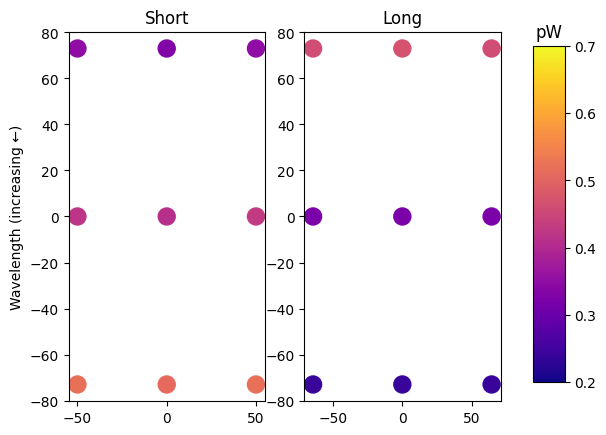

In [14]:
# VISUALIZE POWER DISTRIBUTION
clim = [0.2,0.7]
xySW=powerSWsm['Location'].str.extract(r'\s*\(\s*(?P<x>[+\-0-9]*)\s*,\s*(?P<y>[+\-0-9]*)')
xySW['x']=_pd.to_numeric(xySW['x'])
xySW['y']=_pd.to_numeric(xySW['y'])
xyLW=powerLWsm['Location'].str.extract(r'\s*\(\s*(?P<x>[+\-0-9]*)\s*,\s*(?P<y>[+\-0-9]*)')
xyLW['x']=_pd.to_numeric(xyLW['x'])
xyLW['y']=_pd.to_numeric(xyLW['y'])
fig,ax = _plt.subplots(nrows=1,ncols=2)
scL=ax[1].scatter(xySW['y'],xySW['x'],c=powerSWsm['PTOTAL'],s=150,vmin=clim[0],vmax=clim[1],cmap='plasma')
ax[0].set_ylabel('Wavelength (increasing ←)')
ax[0].set_title('Short')
scR=ax[0].scatter(xyLW['y'],xyLW['x'],c=powerLWsm['PTOTAL'],s=150,vmin=clim[0],vmax=clim[1],cmap='plasma')
ax[1].set_title('Long')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(scL, cax=cbar_ax,cmap='plasma')
cbar_ax.set_title('pW')

In [15]:
# Make a NOISE summary table
# Reminder: ['Det','FPUfilt','Grating','Slit','Slitfilt','Lyot','Lyotfilt','VCS1','VCS2','Window','Secondary','Primary','Obscuration','Spider','Sky']
noiseSW = _pd.concat((bandsSW[['Location','lam','EffSky']].copy(), bandsSW.filter(regex='^NEP.+')), axis=1)
noiseSW['NEPCold'] = _np.sqrt(noiseSW['NEPFPUfilt']**2+noiseSW['NEPGrating']**2 + noiseSW['NEPSlit']**2 + noiseSW['NEPSlitfilt']**2 + noiseSW['NEPLyot']**2 + noiseSW['NEPLyotfilt']**2)
noiseSW['NEPWarm'] = _np.sqrt(noiseSW['NEPSecondary']**2 + noiseSW['NEPPrimary']**2 + noiseSW['NEPObscuration']**2 + noiseSW['NEPSpider']**2)
noiseSW['NEPTotal'] = _np.sqrt(noiseSW['NEPBox']**2 + noiseSW['NEPCold']**2 + noiseSW['NEPVCS1']**2 + noiseSW['NEPVCS2']**2 + noiseSW['NEPWindow']**2 + noiseSW['NEPWarm']**2 + noiseSW['NEPSky']**2)
for col in noiseSW.filter(regex='^NEP.+').columns:
    noiseSW[col] = (noiseSW[col]*1e18).round(2)
noiseSW['EffSky'] = noiseSW['EffSky'].round(3)

noiseLW = _pd.concat((bandsLW[['Location','lam','EffSky']].copy(), bandsLW.filter(regex='^NEP.+')), axis=1)
noiseLW['NEPCold'] = _np.sqrt(noiseLW['NEPFPUfilt']**2+noiseLW['NEPGrating']**2 + noiseLW['NEPSlit']**2 + noiseLW['NEPSlitfilt']**2 + noiseLW['NEPLyot']**2 + noiseLW['NEPLyotfilt']**2)
noiseLW['NEPWarm'] = _np.sqrt(noiseLW['NEPSecondary']**2 + noiseLW['NEPPrimary']**2 + noiseLW['NEPObscuration']**2 + noiseLW['NEPSpider']**2)
noiseLW['NEPTotal'] = _np.sqrt(noiseLW['NEPBox']**2 + noiseLW['NEPCold']**2 + noiseLW['NEPVCS1']**2 + noiseLW['NEPVCS2']**2 + noiseLW['NEPWindow']**2 + noiseLW['NEPWarm']**2 + noiseLW['NEPSky']**2)
for col in noiseLW.filter(regex='^NEP.+').columns:
    noiseLW[col] = (noiseLW[col]*1e18).round(2)
noiseLW['EffSky'] = noiseLW['EffSky'].round(3)

In [16]:
# Print compact NOISE summary
cols = ['Location','lam','EffSky','NEPBox','NEPCold','NEPVCS1','NEPVCS2','NEPWindow','NEPWarm','NEPTotal']
print('SW Camera Noise [aW/rtHz]')
noiseSW[cols]

SW Camera Noise [aW/rtHz]


,Location,lam,EffSky,NEPBox,NEPCold,NEPVCS1,NEPVCS2,NEPWindow,NEPWarm,NEPTotal
0,"(73, -64)",235.60,0.187,3.58,0.16,1.53,12.55,15.22,17.09,26.70
1,"(73, 0)",237.25,0.212,3.58,0.16,1.57,12.86,15.60,17.08,26.97
2,"(73, 64)",235.60,0.188,3.58,0.16,1.53,12.55,15.23,17.10,26.71
3,"(0, -64)",279.50,0.162,3.59,0.34,1.14,9.15,11.10,13.81,20.36
4,"(0, 0)",281.40,0.182,3.59,0.35,1.16,9.33,11.32,13.40,20.24
5,"(0, 64)",279.50,0.162,3.59,0.34,1.13,9.13,11.07,13.77,20.31
6,"(-73, -64)",318.40,0.141,3.59,0.56,0.89,7.09,8.60,11.45,16.43
7,"(-73, 0)",320.75,0.144,3.59,0.57,0.87,6.96,8.44,10.83,16.17
8,"(-73, 64)",318.40,0.141,3.59,0.56,0.89,7.09,8.59,11.43,16.41


In [17]:
print('LW Camera Noise [aW/rtHz]')
noiseLW[cols]

LW Camera Noise [aW/rtHz]


,Location,lam,EffSky,NEPBox,NEPCold,NEPVCS1,NEPVCS2,NEPWindow,NEPWarm,NEPTotal
0,"(-73, -50.75)",312.75,0.212,9.88,0.48,1.10,8.77,10.63,13.58,22.05
1,"(-73, 0)",314.00,0.218,9.88,0.49,1.10,8.79,10.66,13.64,21.93
2,"(-73, 50.75)",312.75,0.213,9.88,0.48,1.10,8.78,10.66,13.61,22.09
3,"(0, -50.75)",370.50,0.185,9.89,0.82,0.82,6.44,7.80,10.87,18.07
4,"(0, 0)",371.50,0.176,9.89,0.84,0.80,6.24,7.57,10.63,17.70
5,"(0, 50.75)",370.50,0.186,9.89,0.82,0.82,6.48,7.85,10.95,18.16
6,"(73, -50.75)",422.50,0.147,9.89,1.16,0.62,4.75,5.75,8.54,15.13
7,"(73, 0)",423.90,0.136,9.89,1.18,0.59,4.54,5.49,8.13,14.73
8,"(73, 50.75)",422.50,0.147,9.89,1.16,0.62,4.75,5.76,8.55,15.14
